In [19]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy import ndimage
import math

In [20]:
pixelReplace = 1
pourcentage = 8
taille_fenetre = 800


id_patient = 22
path = 'C:/Users/Sanchez/Documents/JFR/DATA/patient_' + str(id_patient)

In [21]:
fichiers_dicom = [os.path.join(path, fichier) for fichier in os.listdir(path) if fichier.endswith('.dcm')]
fichiers_dicom.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)

nombre_de_fichiers = len(fichiers_dicom)
nombre_a_afficher = int(nombre_de_fichiers * (pourcentage / 100))

derniers_fichiers_dicom = []
derniers_fichiers_dicom_brut = [] 
for fichier in fichiers_dicom[-nombre_a_afficher:]:
    dernier_fichier = pydicom.dcmread(fichier)
    derniers_fichiers_dicom_brut.append(dernier_fichier)
    derniers_fichiers_dicom.append(dernier_fichier.pixel_array)

In [22]:
# Function to take care of teh translation and windowing. 
def window_image(img, window_center,window_width, intercept, slope, rescale=True):
    img = (img*slope +intercept) #for translation adjustments given in the dicom file. 
    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img[img<img_min] = img_min #set img_min for all HU levels less than minimum HU level
    img[img>img_max] = img_max #set img_max for all HU levels higher than maximum HU level
    if rescale: 
        img = (img - img_min) / (img_max - img_min)*255.0 
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [23]:
def cancelNoise(data):
    Width = 600
    Level = 600
    
    image = data.pixel_array
    window_center, window_width, intercept, slope = get_windowing(data)
    
    output = window_image(image, Level, Width, intercept, slope, rescale = True)

    return output

derniers_fichiers_dicom_WT_Noise =  list(map(cancelNoise, derniers_fichiers_dicom_brut))

print(len(derniers_fichiers_dicom_WT_Noise))

64


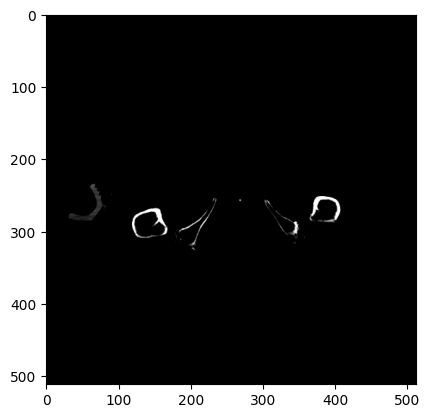

In [24]:
plt.imshow(derniers_fichiers_dicom_WT_Noise[len(derniers_fichiers_dicom_WT_Noise)//2], cmap= 'gray')
plt.show()

In [25]:
def create_video(lsit):
    nom_video_sortie = 'video_patient' + str(id_patient) + '.avi'
    codec = cv2.VideoWriter_fourcc(*'XVID')
    fps = 10  
    largeur, hauteur = pydicom.dcmread(fichiers_dicom[0]).pixel_array.shape
    video_writer = cv2.VideoWriter(nom_video_sortie, codec, fps, (largeur, hauteur))

    for image in lsit:
        image = (image / np.max(image) * 255).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convertissez en image couleur
        video_writer.write(image)

    video_writer.release()

def color_bone(x, max_pixel):
        if x > max_pixel - 2000 :
            return pixelReplace
        else :
            return 0

def nb_bone(matrice):
    etiquettes, nombre_de_formes = ndimage.label(matrice > 0.6)
    res = []
    for i in range(1, nombre_de_formes + 1):  
        pixels_forme = (etiquettes == i)
        coordonnees_pixels = np.argwhere(pixels_forme)
        if len(coordonnees_pixels) < 300 :
            continue

        centre_x = np.mean(coordonnees_pixels[:, 0])
        centre_y = np.mean(coordonnees_pixels[:, 1])
        
        etiquettes[int(centre_x)][int(centre_y)] = pixelReplace 

        #print(f"Centre de la forme {i} : ({centre_x}, {centre_y})")
        res.append((centre_x, centre_y))


    return res

[(269.26158445440956, 390.9387144992526), (287.5263157894737, 138.59147869674186), (301.5629742033384, 190.90591805766311)]
[(269.18382352941177, 391.2720588235294), (287.8539603960396, 138.54455445544554), (302.4479166666667, 191.74652777777777)]
[(269.4215976331361, 391.29289940828403), (287.88819095477385, 137.89195979899498), (304.79956427015253, 193.91067538126362)]
[(269.63065693430656, 391.03503649635036), (287.69062901155326, 138.1193838254172), (305.10653753026634, 194.71670702179176)]
[(269.74886535552196, 389.7957639939486), (287.2231075697211, 137.90969455511288), (305.5, 193.99761904761905)]
[(269.5859375, 389.253125), (287.5140186915888, 137.6648865153538), (304.62566844919786, 195.3903743315508)]
[(269.7251552795031, 388.7577639751553), (287.6154873164219, 137.6008010680908), (304.6865284974093, 194.31865284974094)]
[(269.1049284578696, 388.70588235294116), (287.76494565217394, 136.9673913043478), (304.23746701846966, 194.37203166226914)]
[(270.015479876161, 388.20433436

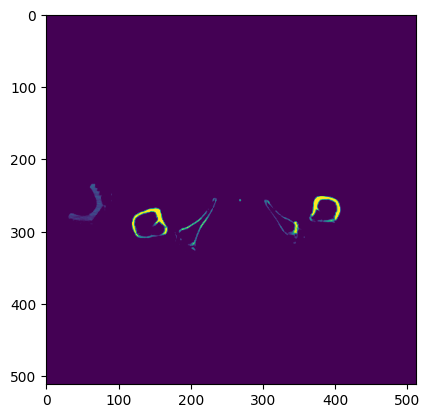

In [26]:
Bone_Image = []
for fichier in derniers_fichiers_dicom_WT_Noise:
    image_matrice = fichier
    mean_pixel, max_pixel = np.mean(image_matrice), np.max(image_matrice)
    new_image =  image_matrice
    femur_center = nb_bone(image_matrice)
    print(femur_center)
    for x,y in femur_center:
        for i in range(-5, 6):
            new_image[int(x + i)][int(y)] = pixelReplace 
            new_image[int(x)][int(y + i)] = pixelReplace 

    x1,y1 = femur_center[0]
    x2,y2 = femur_center[1]

    x3,y3 = int((x1 + x2) /2), int((y1 + y2)/2 )
    for i in range(-10, 11):
        new_image[int((x1 + x2) /2) + i][int((y1 + y2)/2 )] = pixelReplace 
        new_image[int((x1 + x2) /2)][int((y1 + y2)/2 ) + i] = pixelReplace 
    Bone_Image.append(new_image)

plt.imshow(Bone_Image[len(Bone_Image)//2])
plt.show()


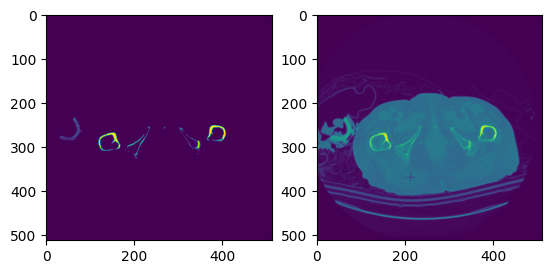

In [27]:
res = []
for new_image in Bone_Image:
    dx = x2 - x1
    dy = y2 - y1
    d = -110
    norme = math.sqrt(dx**2 + dy**2)

    # Normalisation du vecteur 
    ux = dx / norme
    uy = dy / norme

    vx = -uy
    vy = ux

    vx *= d
    vy *= d

    x = x3 + vx
    y = y3 + vy

    for i in range(-10, 11):
            new_image[int(x + i)][int(y)] = pixelReplace 
            new_image[int(x)][int(y + i)] = pixelReplace 
    res.append((new_image,(x, y)))


image, center = res[len(res)//2]
plt.figure()

plt.subplot(1,2, 1)
plt.imshow(image)
plt.subplot(1,2, 2)


image_cross = np.copy(derniers_fichiers_dicom[len(res)//2])
for i in range(-10, 11):
            image_cross[int(x + i)][int(y)] = pixelReplace 
            image_cross[int(x)][int(y + i)] = pixelReplace 
plt.imshow(image_cross)
plt.show()


10201
HOMME


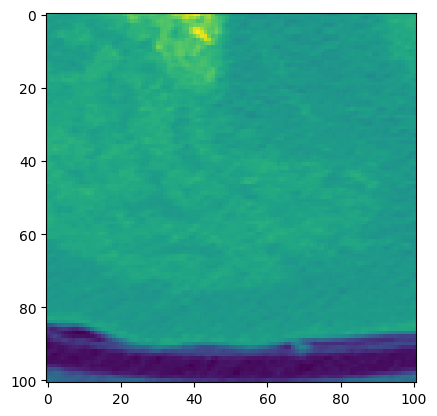

In [28]:
taille_f = 100 # pixels = taille_f **2 
image = derniers_fichiers_dicom[len(res)//2 ]
fenetre = image[int(x - taille_f // 2) : int(x + taille_f // 2 + 1),
            int(y - taille_f // 2 ): int(y + taille_f // 2 + 1)]

pixels_blanc = np.sum(fenetre > 0)
print(pixels_blanc)
if pixels_blanc > 5000 :
    print("HOMME")
else:
    print("FEMME")
plt.imshow(fenetre)
plt.show()
